## Introduction

**This notebook is modification of [Ruslan Baynazarov's](https://www.kaggle.com/hocop1) baseline kernel ver.14 [CenterNet Baseline](https://www.kaggle.com/hocop1/centernet-baseline/notebook) with PL score = 0.038,  
The uploaded model has been trained with the code below for 6 epochs (appx.6 hours) without image augmentations. Here it is to be trained for another 3 epochs.
**
#### The changes I made in the order of the perceived significance to the CV/PL score:

1) changed dropout rate in the EfficientNet B0 base model from 0.2 to 0.02

2) select threshold = -1.5 to filter logits so that the ratio of number of predicted cars to number of images approximates the one of the training set  

3) use test_masks to remove cars from test predictions

4) cars appearing outside of image boundaries are dropped (removed 997 cars out of 49,626 total )

5) Removed broken images thanks to https://www.kaggle.com/c/pku-autonomous-driving/discussion/117621

6) changed StepLR learning rate scheduler to MultiStepLR (gamma=0.5)

7) pixel wise augmentations (albumentations lib)

8) normalized images with subtracting total means per channel and dividing by standard deviation

All other building blocks laid out in CenterNet Baseline kernel ver.14 are intact.
(preprocessing, efficientnet-B0 backbone, Adam optimizer)

### What did not work. 
- using efficientnet B4, B5. The reason might be that the batch size of only 1 image could be fit to Tesla P100 GPU
- gradient accumulation did not improve score. Batch Normalization layers are quoted to be the possible reason
- was not able to change BatchNorm to GroupNorm, and I am still not sure if it would help (would be delighted if you could comment with lines of such code)

### References:

Took 3D visualization code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car
CenterNet paper https://arxiv.org/pdf/1904.07850.pdf
CenterNet repository https://github.com/xingyizhou/CenterNet

Will be grateful for pointing to the bugs and advising corrections



In [1]:
#!pip -q install efficientnet-pytorch

In [2]:
import numpy as np
import pandas as pd
import os, copy, random, cv2, gc, time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from sklearn.model_selection import KFold #train_test_split
from scipy.optimize import minimize

import math
from math import sin, cos

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_, clip_grad_value_
from torchvision import models
from torchvision import transforms, utils

from efficientnet_pytorch import EfficientNet

from albumentations import ( Compose, OneOf, RandomBrightnessContrast,
           RandomGamma, HueSaturationValue, RGBShift, MotionBlur, Blur,
           GaussNoise, ChannelShuffle    
                            )
# not in Colab: MultiplicativeNoise, ISONoise 
osj = os.path.join
osdir = os.listdir

base_seed = 1289
def torch_seed_everything(seed=base_seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

torch_seed_everything()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if device == 'cuda':
    torch.cuda.empty_cache()
    model, optimizer, loss =0,0,0
    gc.collect()
    
#!nvidia-smi

cuda


In [4]:
platform =  'local'  #'Kaggle' # 'Colab' # 'gcp'
#
#if platform == 'Colab':
#    from google.colab import drive
#    drive.mount("/content/drive", force_remount=False)

In [5]:
debug = False
#debug = True

effnet_ver = 'b4' #'b4'
dropout_rate = 0.02

is_resume_train = False #False #True
n_samples = 100_000 if not debug else 20

#img_h, img_w =  512, 2048
img_h, img_w =  683, 2049

img_orig_h, img_orig_w = 2710, 3384
model_scale = 8

batch_size =2
num_epochs = 16 if not debug else 2
num_epochs_resume = 3 if not debug else 2
start_epoch = 0
grad_accu_steps = 2 #32 // batch_size if not debug else 1
if debug: 
  grad_accu_steps = 1 #2    #4 // batch_size
  
num_splits = 8 #8
fold_to_train = 3

date_time_str = time.strftime("%d_%m_time_%H_%M", time.localtime())

path_dict =     {#'Kaggle': '../input/pku-autonomous-driving/',
                #'Colab': './drive/My Drive/Colab/Peking/Data/',
                # 'gcp': 'gs://peking_12/data/raw_data',
                'local': '/home/hy/pkuad/'}
train_test_path_dict = {'Kaggle': '../input/pku-autonomous-driving/',
                 #       'Colab': './drive/My Drive/Colab/Peking/Data/', #Data_512_2048',
                 #       'gcp': 'gs://peking_12/data/raw_data',
                         'local': '/home/hy/pkuad/'}
path_out_dict = {#'Kaggle': './',
                 #'Colab': f"./drive/My Drive/Colab/Peking/Output/Output_kaggle_eff_B0_{date_time_str}",
                 #'Colab': "./drive/My Drive/Colab/Peking/Output/Out_eff_B2_28_12",
                 #'gcp': f"/home/ik/peking/logs/output_{date_time_str}",
                 'local': f"/home/hy/pkuad/Output_eff_{date_time_str}"}

path = path_dict[platform]
train_test_path = train_test_path_dict[platform]
out_path = path_out_dict[platform]


#prev_out_path = "./drive/My Drive/Colab/Peking/Output/Keep_outputs/PL_047_cv_3045_eff_b0_dropout_change_resume_KGL"
#prev_model_fn_path = osj(prev_out_path, "model_fld_3_islastepoch_0_date_02_01_time_13_59.pth")
prev_model_fn_path = '/home/hy/pkuad/model_fld_3_epoch_end_date_02_01_time_06_25.pth'

if platform != 'Kaggle':
    if not os.path.exists(out_path): os.mkdir(out_path)

print("\ntrain and test images dir:", train_test_path)
print("\ntrain.csv, samples_submission.csv, ... directory:", path)
print("\nlogs, output dir:", out_path)
print("\npath directory list:", os.listdir(path))   


train and test images dir: /home/hy/pkuad/

train.csv, samples_submission.csv, ... directory: /home/hy/pkuad/

logs, output dir: /home/hy/pkuad/Output_eff_05_01_time_12_44

path directory list: ['center-resnet34-bk-0103.ipynb', 'center-resnet34.py', 'centernet-baseline-b0.py', 'Output_eff_05_01_time_10_52', 'model_fld_3_epoch_end_date_02_01_time_06_25.pth', 'camera', 'train_masks', '.ipynb_checkpoints', 'history_final_fold_3.csv', 'centernet-baseline-b0-bk.ipynb', 'resnet34-sz-2052-1026_0.062.csv', 'Output_eff_05_01_time_12_44', 'car_models_json', 'train.csv', 'model.pth', 'resnet34-sz-2052-1026_0.062.pth', 'Untitled.ipynb', '0105_b0_sz-2052-1026', 'train_images', 'centernet-baseline-b0-steplr.py', 'test_masks', 'test_images', 'Output_eff_05_01_time_12_43', 'center-resnet-bk.ipynb', 'center-resnet34.ipynb', 'car_models', 'centernet-objects-as-points.ipynb', 'Output_eff_05_01_time_08_39', 'sample_submission.csv', 'centernet-baseline-b0-predict.ipynb', 'rb-s-centernet-baseline-pytorch-w

In [6]:
train = pd.read_csv(osj(path, 'train.csv'), nrows = n_samples)
# drop images found in discussions https://www.kaggle.com/c/pku-autonomous-driving/discussion/117621
drop_images = ['ID_1a5a10365', 'ID_4d238ae90.jpg', 'ID_408f58e9f', 'ID_bb1d991f6', 'ID_c44983aeb'] 

train = train[~train['ImageId'].isin(drop_images)]

test = pd.read_csv(osj(path, 'sample_submission.csv'), nrows = n_samples)

# From camera.zip
camera_matrix = np.array([[2304.5479, 0,  1686.2379],
                          [0, 2305.8757, 1354.9849],
                          [0, 0, 1]], dtype=np.float32)

camera_matrix_inv = np.linalg.inv(camera_matrix)
print("train.shape:", train.shape, "\ttest.shape:",  test.shape)
train.head(2)

train.shape: (4258, 2) 	test.shape: (2021, 2)


,ImageId,PredictionString
0,ID_8a6e65317,16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1,ID_337ddc495,66 0.163988 0.192169 -3.12112 -3.17424 6.55331...


In [7]:
def imread(path, fast_mode=False):
    img = cv2.imread(path)
    if not fast_mode and img is not None and len(img.shape) == 3:
        img = np.array(img[:, :, ::-1])
    return img

def str2coords(s, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']):
    '''
    Input:
        s: PredictionString (e.g. from train dataframe)
        names: array of what to extract from the string
    Output:
        list of dicts with keys from `names`
    '''
    coords = []
    for l in np.array(s.split()).reshape([-1, 7]):
        coords.append(dict(zip(names, l.astype('float'))))
        if 'id' in coords[-1]:
            coords[-1]['id'] = int(coords[-1]['id'])
    return coords

def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x


def add_number_of_cars(df):
    """df - train or test"""
    df['numcars'] = [int((x.count(' ')+1)/7) for x in df['PredictionString']]
    return df

In [8]:
DISTANCE_THRESH_CLEAR = 2

def convert_3d_to_2d(x, y, z, fx = 2304.5479, fy = 2305.8757, cx = 1686.2379, cy = 1354.9849):
    # taken from https://www.kaggle.com/theshockwaverider/eda-visualization-baseline
    return x * fx / z + cx, y * fy / z + cy

def optimize_xy(r, c, x0, y0, z0):
    def distance_fn(xyz):
        x, y, z = xyz
        x, y = convert_3d_to_2d(x, y, z0)
        y, x = x, y
        x = (x - img_orig_h // 2) * img_h / (img_orig_h // 2) / model_scale
        x = np.round(x).astype('int')
        y = (y + img_orig_w // 4) * img_w / (img_orig_w * 1.5) / model_scale
        y = np.round(y).astype('int')
        return (x-r)**2 + (y-c)**2
    
    res = minimize(distance_fn, [x0, y0, z0], method='Powell')
    x_new, y_new, z_new = res.x
    return x_new, y_new, z0

def clear_duplicates(coords):
    for c1 in coords:
        xyz1 = np.array([c1['x'], c1['y'], c1['z']])
        for c2 in coords:
            xyz2 = np.array([c2['x'], c2['y'], c2['z']])
            distance = np.sqrt(((xyz1 - xyz2)**2).sum())
            if distance < DISTANCE_THRESH_CLEAR:
                if c1['confidence'] < c2['confidence']:
                    c1['confidence'] = -1
    return [c for c in coords if c['confidence'] > 0]

def extract_coords(prediction, threshold=0):
    logits = prediction[0]
    regr_output = prediction[1:]
    points = np.argwhere(logits > threshold)  #>0
    col_names = sorted(['x', 'y', 'z', 'yaw', 'pitch_sin', 'pitch_cos', 'roll'])
    coords = []
    for r, c in points:
        regr_dict = dict(zip(col_names, regr_output[:, r, c]))
        coords.append(_regr_back(regr_dict))
        coords[-1]['confidence'] = 1 / (1 + np.exp(-logits[r, c]))
        coords[-1]['x'], coords[-1]['y'], coords[-1]['z'] = optimize_xy(r, c, coords[-1]['x'], coords[-1]['y'], coords[-1]['z'])
    coords = clear_duplicates(coords)
    return coords

def coords2str(coords, names=['yaw', 'pitch', 'roll', 'x', 'y', 'z', 'confidence']):
    s = []
    for c in coords:
        for n in names:
            s.append(str(c.get(n, 0)))
    return ' '.join(s)


def get_img_coords(s):
    '''
    Input is a PredictionString (e.g. from train dataframe)
    Output is two arrays:
        xs: x coordinates in the image
        ys: y coordinates in the image
    '''
    coords = str2coords(s)
    xs = [c['x'] for c in coords]
    ys = [c['y'] for c in coords]
    zs = [c['z'] for c in coords]
    P = np.array(list(zip(xs, ys, zs))).T
    img_p = np.dot(camera_matrix, P).T
    img_p[:, 0] /= img_p[:, 2]
    img_p[:, 1] /= img_p[:, 2]
    img_xs = img_p[:, 0]
    img_ys = img_p[:, 1]
    img_zs = img_p[:, 2] # z = Distance from the camera
    return img_xs, img_ys

In [9]:
def _regr_preprocess(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] / 100
    regr_dict['roll'] = rotate(regr_dict['roll'], np.pi)
    regr_dict['pitch_sin'] = sin(regr_dict['pitch'])
    regr_dict['pitch_cos'] = cos(regr_dict['pitch'])
    regr_dict.pop('pitch')
    regr_dict.pop('id')
    return regr_dict

def _regr_back(regr_dict):
    for name in ['x', 'y', 'z']:
        regr_dict[name] = regr_dict[name] * 100
    regr_dict['roll'] = rotate(regr_dict['roll'], -np.pi)
    
    pitch_sin = regr_dict['pitch_sin'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    pitch_cos = regr_dict['pitch_cos'] / np.sqrt(regr_dict['pitch_sin']**2 + regr_dict['pitch_cos']**2)
    regr_dict['pitch'] = np.arccos(pitch_cos) * np.sign(pitch_sin)
    return regr_dict

def preprocess_image(img):
    img = img[img.shape[0] // 2:]
    bg = np.ones_like(img) * img.mean(1, keepdims=True).astype(img.dtype)
    bg = bg[:, :img.shape[1] // 4]
    img = np.concatenate([bg, img, bg], 1)
    img = cv2.resize(img, (img_w, img_h))
    return img

def get_mask_and_regr(img_orig_height, img_orig_width, labels):
    mask = np.zeros([img_h // model_scale, img_w // model_scale], dtype='float32')
    regr_names = ['x', 'y', 'z', 'yaw', 'pitch', 'roll']
    regr = np.zeros([img_h // model_scale, img_w // model_scale, 7], dtype='float32')
    coords = str2coords(labels)
    xs, ys = get_img_coords(labels)
    for x, y, regr_dict in zip(xs, ys, coords):
        x, y = y, x
        x = (x - img_orig_height // 2) * img_h / (img_orig_height // 2) / model_scale
        x = np.round(x).astype('int')
        y = (y + img_orig_width // 4) * img_w / (img_orig_width * 1.5) / model_scale
        y = np.round(y).astype('int')
        if x >= 0 and x < img_h // model_scale and y >= 0 and y < img_w // model_scale:
            mask[x, y] = 1
            regr_dict = _regr_preprocess(regr_dict)
            regr[x, y] = [regr_dict[n] for n in sorted(regr_dict)]
    return mask, regr

## Remove cars with coordinates outside the image boundaries
There are many cars coordinates that fall outside of image as noted in CenterNet Baseline kernel
I remove them here from train

In [10]:
def remove_out_image_cars(df):

        def isnot_out(x,y):
            # are x,y coordinates within boundaries of the image
            return (x>=0)&(x<=img_orig_w)&(y>=0)&(y<=img_orig_h)

        df = add_number_of_cars(df)

        new_str_coords = []
        counter_all_ls = []
        for idx,str_coords in enumerate(df['PredictionString']):
            coords = str2coords(str_coords, names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z'])
            xs, ys = get_img_coords(str_coords)
            counter = 0
            coords_new = []
            
            for (item,x,y) in zip(coords, xs, ys):
                if isnot_out(x, y):
                    coords_new.append(item)
                    counter += 1
                                
            new_str_coords.append(coords2str(coords_new,  names=['id', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']))
            counter_all_ls.append(counter)
            
        df['new_pred_string']  = new_str_coords 
        df['new_numcars'] = counter_all_ls

        print("num of cars outside image bounds:", df['numcars'].sum()-df['new_numcars'].sum(), 
            "out of all", df['numcars'].sum(), " cars in train")

        del df['PredictionString'], train['numcars']
        df.rename(columns={'new_pred_string': 'PredictionString'}, inplace=True)

        return df
    
train = remove_out_image_cars(train)

num of cars outside image bounds: 997 out of all 49626  cars in train


### Assert that new car coordinates are within image boundaries

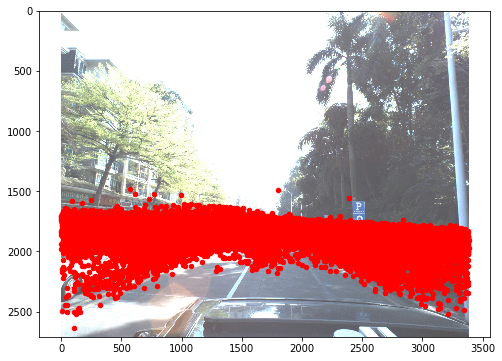

In [11]:
xs, ys = [], []
train_image_idx =6

for ps in train['PredictionString']:
    x, y = get_img_coords(ps)
    xs += list(x)
    ys += list(y)

plt.figure(figsize=(12,6))
plt.imshow(imread(osj(train_test_path,'train_images', train['ImageId'][train_image_idx] + '.jpg')), alpha=0.7)
plt.scatter(xs, ys, color='red', s=20, alpha=1);

Used code from https://www.kaggle.com/zstusnoopy/visualize-the-location-and-3d-bounding-box-of-car, but made it one function

In [12]:
# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))


def draw_line(image, points):
    color = (255, 0, 0)
    cv2.line(image, tuple(points[0][:2]), tuple(points[3][:2]), color, 16)
    cv2.line(image, tuple(points[0][:2]), tuple(points[1][:2]), color, 16)
    cv2.line(image, tuple(points[1][:2]), tuple(points[2][:2]), color, 16)
    cv2.line(image, tuple(points[2][:2]), tuple(points[3][:2]), color, 16)
    return image


def draw_points(image, points):
    for (p_x, p_y, p_z) in points:
        cv2.circle(image, (p_x, p_y), int(1000 / p_z), (0, 255, 0), -1)
    return image


def visualize(img, coords):
    x_l = 1.02
    y_l = 0.80
    z_l = 2.31
    
    img = img.copy()
    for point in coords:
        # Get values
        x, y, z = point['x'], point['y'], point['z']
        yaw, pitch, roll = -point['pitch'], -point['yaw'], -point['roll']
        # Math
        Rt = np.eye(4)
        t = np.array([x, y, z])
        Rt[:3, 3] = t
        Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
        Rt = Rt[:3, :]
        P = np.array([[x_l, -y_l, -z_l, 1],
                      [x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, z_l, 1],
                      [-x_l, -y_l, -z_l, 1],
                      [0, 0, 0, 1]]).T
        img_cor_points = np.dot(camera_matrix, np.dot(Rt, P))
        img_cor_points = img_cor_points.T
        img_cor_points[:, 0] /= img_cor_points[:, 2]
        img_cor_points[:, 1] /= img_cor_points[:, 2]
        img_cor_points = img_cor_points.astype(int)
        # Drawing
        img = draw_line(img, img_cor_points)
        img = draw_points(img, img_cor_points[-1:])
    
    return img

### Albumentations augmentation
As noted in Discussions, test images have been augmented pixel-wise and with horizontal flip.
Only pixel augmentations are applied here

In [13]:
albu_list = [RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=0.3),
           RandomGamma(p=0.2), HueSaturationValue(p=0.3), RGBShift(p=0.3), MotionBlur(p=0.1), Blur(p=0.1), 
           GaussNoise(var_limit=(20,100), p=0.2), 
           ChannelShuffle(p=0.2)]

# NOT in colab version: MultiplicativeNoise(multiplier=(0.7, 1.2), p=0.2), ISONoise(p=0.2),               
# GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5)

p_transform_train = 0.1
albu_transform_train = Compose(albu_list, p=p_transform_train)

p_transform_val = 0.05
albu_transform_valid = Compose(albu_list, p=p_transform_val)

In [14]:
def aug_visualize(original_imgs: list, augmented_images: list):
    fig_height = 8*len(original_imgs)
    fig_width = 20
    f, ax = plt.subplots(len(original_imgs), 2, figsize=(fig_width, fig_height))
    
    for i, (img, aug_img) in enumerate(zip(original_imgs, augmented_images)):
        assert len(img.shape)==3 & img.shape[2]==3
        ax[i,0].imshow(img)
        ax[i,0].set_title(f"Original image ", fontsize=12)
        ax[i,1].imshow(aug_img)
        ax[i,1].set_title('Augmented image', fontsize=12)

### Random augmentations demo

"""
num_imgs_to_show  = 4
p_transform_demo = 1
albu_transform_demo = Compose(albu_list, p=p_transform_train)

assert num_imgs_to_show < 10
paths = random.sample(train['ImageId'].tolist(), num_imgs_to_show)
original_imgs = [cv2.imread(osj(train_test_path,'train_images',path+'.jpg' )) for path in paths]
augmented_imgs = [albu_transform_demo(image=img)['image'] for img in original_imgs]
aug_visualize(original_imgs, augmented_imgs)

del augmented_imgs, albu_transform_demo, paths
_ = gc.collect()
"""

# PyTorch Dataset

In [15]:
means = np.array([80.302637, 73.818344, 69.698726]).reshape(1,1,3)
stds = np.array([52.455102, 52.848600, 50.285960]).reshape(1,1,3)
# for original image sizes:
            #means = np.array([145.375023, 136.948063, 122.689194]).reshape(1,1,3)
            #stds = np.array([95.254658, 94.717646, 85.960257]).reshape(1,1,3)

def normalize(img, means, stds, tensor=False):
    return (img - means)/stds

def denormalize(img, means, stds, resize_to_original=False):  
    """ 
    input is numpy
    convert back to (0,255) and moveaxis from 3,x,x to x,x,3 after denormalizing - multiply by stds and add means
    img is a torch tensor"""

    img = np.moveaxis(img, 0, 2)
    img = img*stds + means
    img = np.clip(img, 0, 255).astype('uint8')

    if resize_to_original:
        # revert def preprocess_image()
        img = img[:,(img_w//4): (img_w - img_w//4),:]
        img = cv2.copyMakeBorder( img, img.shape[0], 0,0,0, cv2.BORDER_CONSTANT) #, borderType)
        img = cv2.resize(img, (img_orig_w, img_orig_h))
            
    return img


class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, root_dir_dropmasks=osj(path,'test_masks/{}.jpg'), training=True, transform=None):
        self.df = dataframe
        self.root_dir = root_dir
        self.root_dir_dropmasks = root_dir_dropmasks
        self.transform = transform
        self.training = training
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #import pdb; pdb.set_trace()
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img = imread(img_name, True)
        img = preprocess_image(img)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        img = normalize(img, means, stds)
        img = np.rollaxis(img, 2, 0)             
        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(img_orig_h, img_orig_w, labels)
            regr = np.rollaxis(regr, 2, 0)
            dropmask = 0
        else:
            mask, regr = 0, 0 
            dropmask_name = self.root_dir_dropmasks.format(idx)
            if os.path.isfile(dropmask_name):
                dropmask = imread(dropmask_name, True) #, 'test_masks', idx+'.jpg'))
                dropmask = preprocess_image(dropmask)
            else:
                dropmask = np.zeros((img_h, img_w, 3))
            #mask = preprocess_image(mask)

        img = torch.as_tensor(img, dtype=torch.float32) #/255)
        mask = torch.as_tensor(mask, dtype=torch.float32)
        regr = torch.as_tensor(regr, dtype=torch.float32)
        dropmask = torch.as_tensor(dropmask, dtype=torch.float32)
        
        return [img, mask, regr, dropmask]

class backup_CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, dataframe, root_dir, training=True, transform=None, means = means, stds = stds):
        self.df = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.training = training
        self.means = means
        self.stds = stds
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
         
        
        
        # Get image name
        idx, labels = self.df.values[idx]
        img_name = self.root_dir.format(idx)
        
        # Read image
        img = imread(img_name, True)
        img = preprocess_image(img)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        img = normalize(img, self.means, self.stds)
        img = np.rollaxis(img, 2, 0)
                        
        # Get mask and regression maps
        if self.training:
            mask, regr = get_mask_and_regr(labels)
            regr = np.rollaxis(regr, 2, 0)
        else:
            mask, regr = 0, 0
        
        img = torch.Tensor(img);    mask = torch.Tensor(mask);    regr = torch.Tensor(regr)
        
        return [img, mask, regr]

## Build Pytorch Model

In [16]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [17]:
def set_dropout(model, drop_rate):
    # source: https://discuss.pytorch.org/t/how-to-increase-dropout-rate-during-training/58107/4
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = drop_rate
            print("name:", name)
            print("children:\n", child)


def effnet_dropout(drop_rate):
    base_model0 = EfficientNet.from_pretrained(f"efficientnet-{effnet_ver}")
    set_dropout(base_model0, drop_rate)
    return base_model0


class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes, drop_rate):
        super(MyUNet, self).__init__()
        
        self.drop_rate = dropout_rate
        self.base_model = effnet_dropout(drop_rate = self.drop_rate)
        self.conv0 = double_conv(5, 64)
        self.conv1 = double_conv(64, 128)
        self.conv2 = double_conv(128, 512)
        self.conv3 = double_conv(512, 1024)
        
        self.mp = nn.MaxPool2d(2)
        
        if effnet_ver == 'b0': self.up1 = up(1282 + 1024, 512)
        elif effnet_ver == 'b2': self.up1 = up(1410 + 1024, 512)
        elif effnet_ver == 'b4': self.up1 = up(1794 + 1024, 512)
        elif effnet_ver == 'b5': self.up1 = up(2050 + 1024, 512)
        
        self.up2 = up(512 + 512, 256)
        self.outc = nn.Conv2d(256, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        mesh1 = get_mesh(batch_size, x.shape[2], x.shape[3])
        x0 = torch.cat([x, mesh1], 1)
        
        #import pdb; pdb.set_trace()
        
        x1 = self.mp(self.conv0(x0))
        x2 = self.mp(self.conv1(x1))
        x3 = self.mp(self.conv2(x2))
        x4 = self.mp(self.conv3(x3))
        
        feats = self.base_model.extract_features(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, feats.shape[2], feats.shape[3])
        feats = torch.cat([feats, mesh2], 1)
        
        x = self.up1(feats, x4)
        x = self.up2(x, x3)
        x = self.outc(x)
        return x

In [18]:
def build_model(drop_rate):
    # Gets the GPU if there is one, otherwise the cpu
    print("device:", device)
    model = MyUNet(8, drop_rate).to(device)
    #set_dropout(model, drop_rate=drop_rate)    
    return model

In [19]:
def criter_metric(prediction, mask, regr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
        
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    # Sum
    loss = mask_loss + regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss, mask_loss, regr_loss


w_mask = 0.1; w_regr = 0.9
w_mask = torch.tensor( w_mask, device=device); w_regr = torch.tensor( w_regr, device=device)
gamma=torch.tensor(5, device=device)

def criter_objective(prediction, mask, regr, size_average=True):
            
    pred_mask = torch.sigmoid(prediction[:, 0])
        
    #mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * ((1-pred_mask)**gamma)* torch.log(pred_mask+1e-12)\
               + (1 - mask)*torch.log(1-pred_mask+1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / mask.sum(1).sum(1)
    regr_loss = regr_loss.mean(0)
    
    # Sum
    loss = w_mask*mask_loss + w_regr*regr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [20]:

def evaluate(model, epoch, history=None):
    model.eval()
    val_loss, mask_loss, regr_loss = torch.tensor(0., requires_grad=False), torch.tensor(0., requires_grad=False), torch.tensor(0., requires_grad=False)
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch, _ in dev_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)

            output = model(img_batch)
            
            val_loss_batch, mask_loss_batch, regr_loss_batch = criter_metric(output, mask_batch, regr_batch, size_average=False)
            val_loss += val_loss_batch
            mask_loss += mask_loss_batch
            regr_loss += regr_loss_batch
    
    val_loss /= len(dev_loader.dataset)
    mask_loss /= len(dev_loader.dataset)
    regr_loss /= len(dev_loader.dataset)
            
    return val_loss.cpu().numpy(), mask_loss.cpu().numpy(), regr_loss.cpu().numpy()


def save_checkpoint(state, model_name=None):
        """Save checkpoint if a new best is achieved"""
        
        if not model_name: model_name =  f"model_date_{date_time_str}.pth"
        torch.save(state, osj(out_path, model_name))
            

def train_eval_model(model, epoch, best_val_loss, history=None):
    
    model.train()
    freq_eval = len(train_loader.dataset)//4

    for batch_idx, (img_batch, mask_batch, regr_batch, _) in enumerate(tqdm(train_loader)):
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
                
        output = model(img_batch)
        loss = criter_objective(output, mask_batch, regr_batch)
        train_loss = loss.data.cpu().numpy()
        
        loss = loss / grad_accu_steps 
        loss.backward()

        if (batch_idx+1) % grad_accu_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        lr_value = optimizer.state_dict()['param_groups'][0]['lr']

        cond1 = ((batch_idx+1) % freq_eval)==0   # every freq_eval number of batches
        cond2 = abs(batch_idx-len(train_loader))*10 > len(train_loader)  # if not too close to the end or start of epoch
        is_end_epoch =  ((batch_idx+1) % len(train_loader) ) == 0
        
        if is_end_epoch | (cond1 & cond2):
            t_eval0 = time.time()
            val_loss, mask_val_loss, regr_val_loss = evaluate(model, dev_loader)
            
            #scheduler.step(val_loss)  for LRONPlateu scheduler
            print("\n=========================")
            print(f"epoch={epoch}, batch={batch_idx} => lr={lr_value:.7f}, trn loss={loss:4f}")
            print(f"VAL LOSS: {val_loss:.2f}, \tBest Val Loss: {best_val_loss:.2f} \teval time={(time.time()-t_eval0)/60:.2f} min.")
            print("mask_val_loss:", mask_val_loss, "\tregr_val_loss", regr_val_loss)
            if is_end_epoch: print(f"\n===END of EPOCH {epoch}================")
            
            history.loc[epoch*len(train_loader)+batch_idx, ['train_loss','val_loss', 'lr','mask_val_loss','regr_val_loss']] =\
                            [train_loss, val_loss, lr_value, mask_val_loss, regr_val_loss ]
            history.to_csv(osj(out_path, f'history_{fld}.csv'))
            
            is_best = val_loss < best_val_loss
            best_val_loss = min(val_loss, best_val_loss)
                   
        history.loc[epoch*len(train_loader)+batch_idx, ['train_loss', 'lr']] = [train_loss, lr_value ]
    
    return model, optimizer, history, best_val_loss, val_loss

In [ ]:

train_images_dir = osj(train_test_path,'train_images/{}.jpg')
test_images_dir = osj(train_test_path,'test_images/{}.jpg')

df_test = test
kfold = KFold(n_splits=num_splits, shuffle=True, random_state= base_seed)

fld = fold_to_train
trn_idx, val_idx = list(kfold.split(train))[fld]

train_dataset = CarDataset(train[['ImageId', 'PredictionString']].iloc[trn_idx], train_images_dir,
                           transform = albu_transform_train)
dev_dataset = CarDataset(train[['ImageId', 'PredictionString']].iloc[val_idx], train_images_dir,
                         transform = albu_transform_valid)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

model = build_model(drop_rate=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.AdamW(model.parameters(), lr=0.0015, weight_decay=0.00001)

scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[7,10,14,17,20], gamma=0.5) #milestones=[5,7,8], gamma=0.1)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=max(num_epochs, 10) * len(train_loader) // 8, gamma=0.5)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, 
#                                         verbose=True)
if is_resume_train:
    checkpoint = torch.load(prev_model_fn_path, map_location=device)            
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    n_epochs = num_epochs_resume
    best_val_loss = prev_epoch_val_loss = checkpoint['best_val_loss']
    prev_epoch_val_loss = copy.copy(best_val_loss)
    scheduler.load_state_dict(checkpoint['scheduler'])
    
    del checkpoint; _ = gc.collect()

else: # train from epoch=0 if not resuming training
    epoch_start = 0     
    n_epochs = num_epochs
    best_val_loss, prev_epoch_val_loss = 10e+6, 10e+6

history = pd.DataFrame(np.full((len(train_loader)*n_epochs, 5), fill_value=-1, dtype=np.float32),
                           columns=['train_loss','val_loss','lr','mask_val_loss','regr_val_loss'])

print(f"\n======================\nTrain start. Output directory {out_path}")
print("efficientnet-", effnet_ver, "n_epochs:", n_epochs, "len(train_loader):", len(train_loader))
for epoch in range(epoch_start, n_epochs+epoch_start):
    torch.cuda.empty_cache()
    gc.collect()
    model, optimizer, history, best_val_loss, val_loss = train_eval_model(model, epoch, best_val_loss, history)
    scheduler.step()
    
    is_last_epoch = ( epoch==(n_epochs+epoch_start-1) )
    if (val_loss < prev_epoch_val_loss)|(is_last_epoch):
        params_save_model = { 'epoch': start_epoch + epoch, 'loss': history['train_loss'].iat[-1],
                            'best_val_loss': best_val_loss,
                            'state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict() }
        print(f"Val_loss improved or end training => Saving at epoch {epoch} end w val_loss={val_loss:.2f}, best_val_loss = {best_val_loss:.2f}")
        save_checkpoint(params_save_model, model_name = f"model_fld_{fld}_islastepoch_{is_last_epoch:d}_date_{date_time_str}.pth")
    
    prev_epoch_val_loss = val_loss

history.to_csv(osj(out_path, f"history_final_fold_{fld}.csv"), index=False)

device: cuda
Loaded pretrained weights for efficientnet-b4
name: _dropout
children:
 Dropout(p=0.02, inplace=False)

Train start. Output directory /home/hy/pkuad/Output_eff_05_01_time_12_44
efficientnet- b4 n_epochs: 16 len(train_loader): 1863


/home/hy/anaconda3/envs/badeda/lib/python3.7/site-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch=0, batch=930 => lr=0.0010000, trn loss=4.234122
VAL LOSS: 70.99, 	Best Val Loss: 10000000.00 	eval time=1.87 min.
mask_val_loss: 34.91659 	regr_val_loss 0.5776667

epoch=0, batch=1862 => lr=0.0010000, trn loss=1.804694
VAL LOSS: 43.65, 	Best Val Loss: 70.99 	eval time=1.86 min.
mask_val_loss: 21.34654 	regr_val_loss 0.47600874

===END of EPOCH 0================

Val_loss improved or end training => Saving at epoch 0 end w val_loss=43.65, best_val_loss = 43.65



epoch=1, batch=930 => lr=0.0010000, trn loss=2.460624
VAL LOSS: 46.90, 	Best Val Loss: 43.65 	eval time=1.87 min.
mask_val_loss: 23.068628 	regr_val_loss 0.38238677

epoch=1, batch=1862 => lr=0.0010000, trn loss=1.708675
VAL LOSS: 40.48, 	Best Val Loss: 43.65 	eval time=1.87 min.
mask_val_loss: 19.846527 	regr_val_loss 0.39445007

===END of EPOCH 1================

Val_loss improved or end training => Saving at epoch 1 end w val_loss=40.48, best_val_loss = 40.48



epoch=2, batch=930 => lr=0.0010000, trn loss=1.222908
VAL LOSS: 39.76, 	Best Val Loss: 40.48 	eval time=1.86 min.
mask_val_loss: 19.553804 	regr_val_loss 0.32422101

epoch=2, batch=1862 => lr=0.0010000, trn loss=1.081500
VAL LOSS: 36.52, 	Best Val Loss: 39.76 	eval time=1.86 min.
mask_val_loss: 17.952742 	regr_val_loss 0.30576953

===END of EPOCH 2================

Val_loss improved or end training => Saving at epoch 2 end w val_loss=36.52, best_val_loss = 36.52



epoch=3, batch=930 => lr=0.0010000, trn loss=1.707390
VAL LOSS: 36.75, 	Best Val Loss: 36.52 	eval time=1.86 min.
mask_val_loss: 18.084118 	regr_val_loss 0.29336748

epoch=3, batch=1862 => lr=0.0010000, trn loss=2.114006
VAL LOSS: 36.88, 	Best Val Loss: 36.52 	eval time=1.88 min.
mask_val_loss: 18.135984 	regr_val_loss 0.30312976

===END of EPOCH 3================




epoch=4, batch=930 => lr=0.0010000, trn loss=0.960820
VAL LOSS: 35.67, 	Best Val Loss: 36.52 	eval time=1.87 min.
mask_val_loss: 17.552689 	regr_val_loss 0.28291076

epoch=4, batch=1862 => lr=0.0010000, trn loss=1.148592
VAL LOSS: 35.22, 	Best Val Loss: 35.67 	eval time=1.87 min.
mask_val_loss: 17.301514 	regr_val_loss 0.30845055

===END of EPOCH 4================

Val_loss improved or end training => Saving at epoch 4 end w val_loss=35.22, best_val_loss = 35.22



epoch=5, batch=930 => lr=0.0010000, trn loss=1.033451
VAL LOSS: 34.98, 	Best Val Loss: 35.22 	eval time=1.87 min.
mask_val_loss: 17.215075 	regr_val_loss 0.27646437

epoch=5, batch=1862 => lr=0.0010000, trn loss=1.451759
VAL LOSS: 34.64, 	Best Val Loss: 34.98 	eval time=1.86 min.
mask_val_loss: 17.027174 	regr_val_loss 0.29464242

===END of EPOCH 5================

Val_loss improved or end training => Saving at epoch 5 end w val_loss=34.64, best_val_loss = 34.64



epoch=6, batch=930 => lr=0.0010000, trn loss=1.317562
VAL LOSS: 35.25, 	Best Val Loss: 34.64 	eval time=1.87 min.
mask_val_loss: 17.345781 	regr_val_loss 0.28120697

epoch=6, batch=1862 => lr=0.0010000, trn loss=1.690114
VAL LOSS: 34.41, 	Best Val Loss: 34.64 	eval time=1.86 min.
mask_val_loss: 16.887344 	regr_val_loss 0.31518885

===END of EPOCH 6================

Val_loss improved or end training => Saving at epoch 6 end w val_loss=34.41, best_val_loss = 34.41



epoch=7, batch=930 => lr=0.0005000, trn loss=1.172622
VAL LOSS: 34.35, 	Best Val Loss: 34.41 	eval time=1.86 min.
mask_val_loss: 16.91683 	regr_val_loss 0.25842953

epoch=7, batch=1862 => lr=0.0005000, trn loss=0.872773
VAL LOSS: 34.95, 	Best Val Loss: 34.35 	eval time=1.86 min.
mask_val_loss: 17.209255 	regr_val_loss 0.26772746

===END of EPOCH 7================




epoch=8, batch=930 => lr=0.0005000, trn loss=0.699431
VAL LOSS: 34.64, 	Best Val Loss: 34.35 	eval time=1.88 min.
mask_val_loss: 17.069485 	regr_val_loss 0.24931547

epoch=8, batch=1862 => lr=0.0005000, trn loss=0.559855
VAL LOSS: 36.87, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 18.173615 	regr_val_loss 0.26120412

===END of EPOCH 8================




epoch=9, batch=930 => lr=0.0005000, trn loss=1.146266
VAL LOSS: 35.21, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 17.359135 	regr_val_loss 0.24691454

epoch=9, batch=1862 => lr=0.0005000, trn loss=0.871618
VAL LOSS: 35.75, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 17.627035 	regr_val_loss 0.24858804

===END of EPOCH 9================

Val_loss improved or end training => Saving at epoch 9 end w val_loss=35.75, best_val_loss = 34.35



epoch=10, batch=930 => lr=0.0002500, trn loss=0.352816
VAL LOSS: 38.46, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 18.994892 	regr_val_loss 0.23513938

epoch=10, batch=1862 => lr=0.0002500, trn loss=0.405378
VAL LOSS: 39.89, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 19.705603 	regr_val_loss 0.23813652

===END of EPOCH 10================




epoch=11, batch=930 => lr=0.0002500, trn loss=0.455468
VAL LOSS: 40.49, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 20.013256 	regr_val_loss 0.23255378

epoch=11, batch=1862 => lr=0.0002500, trn loss=0.494104
VAL LOSS: 43.65, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 21.584415 	regr_val_loss 0.24114597

===END of EPOCH 11================




epoch=12, batch=930 => lr=0.0002500, trn loss=0.161895
VAL LOSS: 46.20, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 22.861498 	regr_val_loss 0.23926854

epoch=12, batch=1862 => lr=0.0002500, trn loss=0.265354
VAL LOSS: 44.59, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 22.057203 	regr_val_loss 0.23679864

===END of EPOCH 12================




epoch=13, batch=930 => lr=0.0002500, trn loss=0.285335
VAL LOSS: 44.39, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 21.957539 	regr_val_loss 0.23564948

epoch=13, batch=1862 => lr=0.0002500, trn loss=0.326565
VAL LOSS: 46.01, 	Best Val Loss: 34.35 	eval time=1.87 min.
mask_val_loss: 22.758617 	regr_val_loss 0.24522115

===END of EPOCH 13================



### Join initially uploaded model's history log

In [32]:
history_old = pd.read_csv('/home/hy/pkuad/history_final_fold_3.csv')
history_old = history_old[history_old['val_loss'] > 0]
history_new = history[history['val_loss']>0]
history_new.index = history_new.index + history_old.index.max()+1
history_new = pd.concat([history_old, history_new], axis=0)
history_new.tail()

,train_loss,val_loss,lr,mask_val_loss,regr_val_loss
37259,0.653130,46.007668,0.000250,22.758617,0.245221
38190,0.568208,45.381706,0.000125,22.462370,0.228487
39122,0.307827,49.887863,0.000125,24.723694,0.220232
40053,0.473328,52.238251,0.000125,25.892694,0.226420
40985,0.538488,57.711899,0.000125,28.623348,0.232604


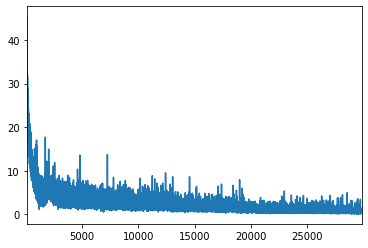

In [33]:
if not debug: history['train_loss'].iloc[100:].plot();

In [34]:
### History of validation loss (including previously trained model)

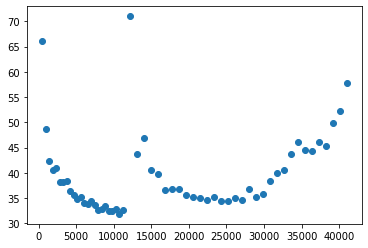

In [35]:
series = history_new.dropna()['val_loss']
plt.scatter(series.index, series);

# Visualize predictions

/home/hy/anaconda3/envs/badeda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


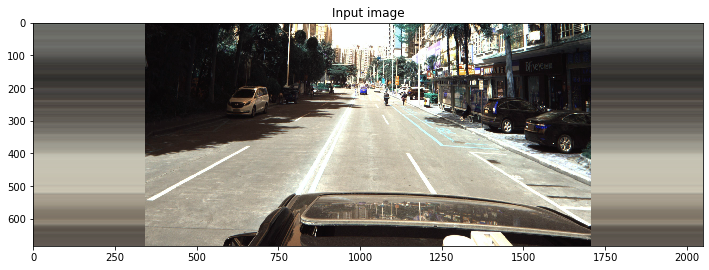

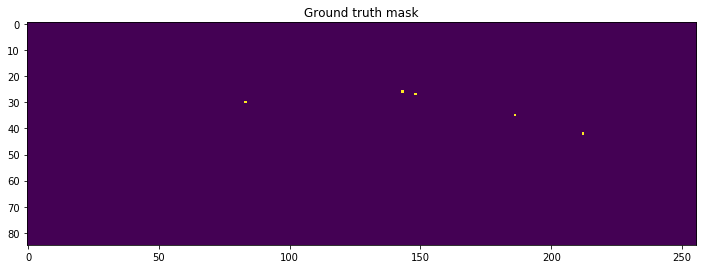

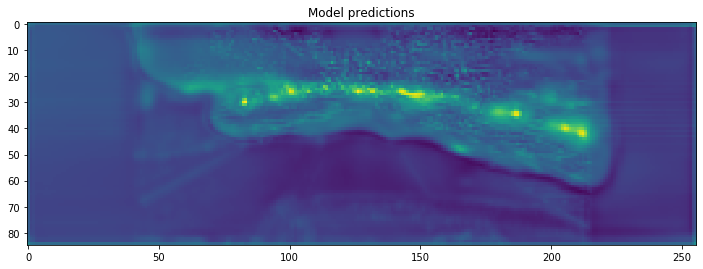

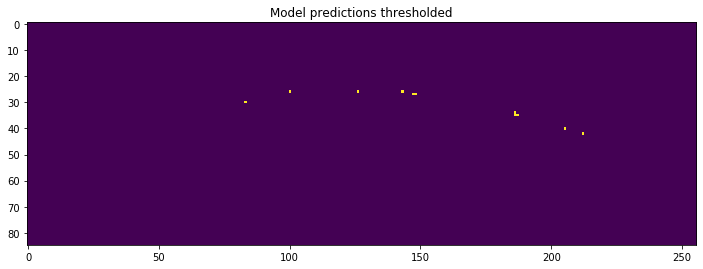

In [36]:
def plot_pred_mask(model, idx, threshold):
    h,w = 12,6
    img, mask, regr, _ = train_dataset[idx] #dev_dataset[0]
    output = model(torch.tensor(img[None]).to(device))
    logits = output[0,0].data.cpu().numpy()

    img = img.data.cpu().numpy()  #.clone().detach()
    img = denormalize(img, means, stds)
    mask = mask.data.cpu().numpy()
    regr = regr.data.cpu().numpy()
     
    plt.figure(figsize=(h,w))
    plt.title('Input image')
    plt.imshow(img)
    plt.show()
    
    plt.figure(figsize=(h,w))
    plt.title('Ground truth mask')
    plt.imshow(mask)
    plt.show()

    plt.figure(figsize=(h,w))
    plt.title('Model predictions')
    plt.imshow(logits)
    plt.show()

    plt.figure(figsize=(h,w))
    plt.title('Model predictions thresholded')
    plt.imshow(logits > threshold0) #0)
    plt.show()
  
threshold0 = -1.5
idx = 0
plot_pred_mask(model, idx, threshold0)

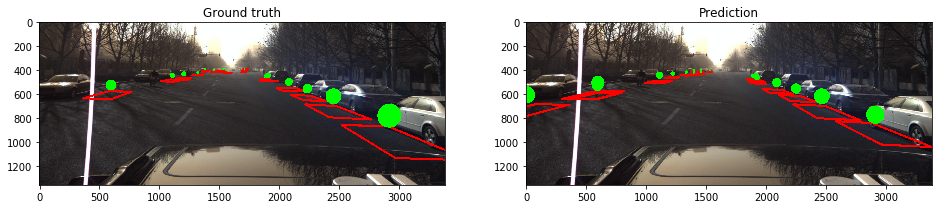

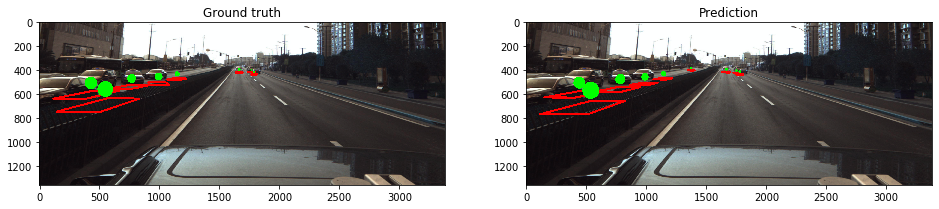

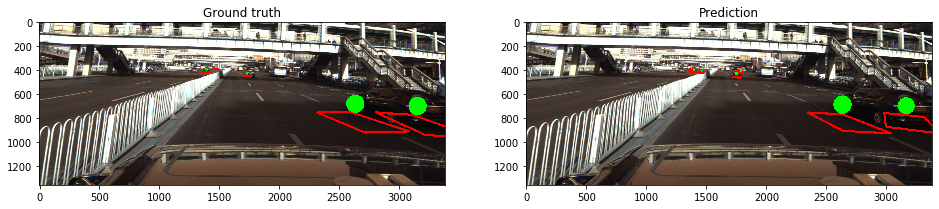

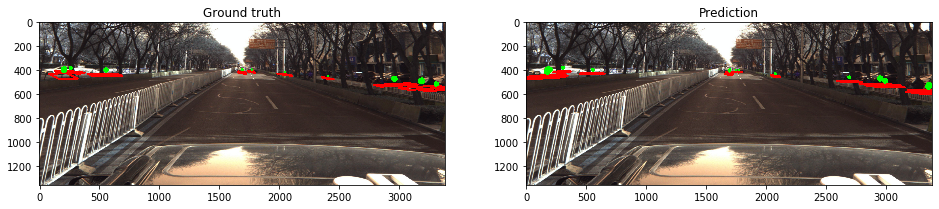

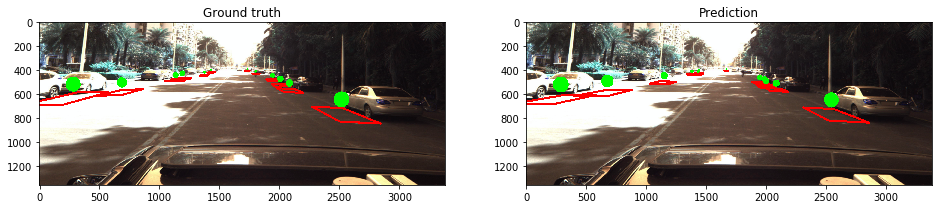

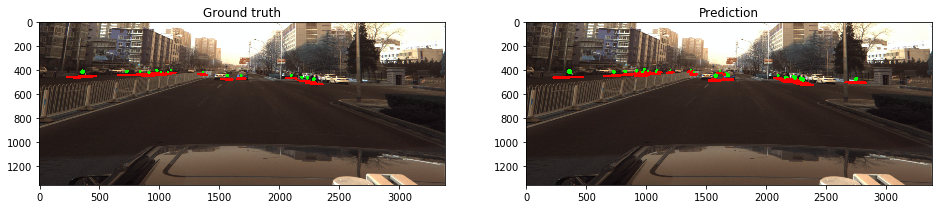

In [37]:
torch.cuda.empty_cache()
gc.collect()
threshold0 = -1.6
n_imgs = 6 if not debug else 2
for idx in random.sample(range(len(dev_dataset)), n_imgs):
    img, mask, regr, _ = dev_dataset[idx]
        
    output = model(img[None].to(device)).data.cpu().numpy()
    img = img.data.cpu().numpy()
    mask = mask.data.cpu().numpy() #
    regr = regr.data.cpu().numpy()
    
    coords_pred = extract_coords(output[0], threshold=threshold0)
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = denormalize(img, means, stds, resize_to_original=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(16,12))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true)[(img.shape[0]//2):])
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred)[(img.shape[0]//2):])
    plt.show()

## Filter Predictions

In [38]:
# load best epoch end model or else initially loaded model

is_last_epoch = False
model_name = f"model_fld_{fld}_islastepoch_{is_last_epoch:d}_date_{date_time_str}.pth"
try:
    checkpoint = torch.load(osj(out_path, model_name), map_location=device)
    print("best model of the current session loaded.")
except:
    checkpoint = torch.load(prev_model_fn_path, map_location=device) 
    print("NO best model in the current session. Previously trained model loaded")

model.load_state_dict(checkpoint['state_dict'])

aaa
/home/hy/pkuad/Output_eff_05_01_time_12_44
model_fld_3_islastepoch_0_date_05_01_time_12_44.pth
/home/hy/pkuad/Output_eff_05_01_time_12_44/model_fld_3_islastepoch_0_date_05_01_time_12_44.pth


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<All keys matched successfully>

In [39]:
def predict_test(model, threshold = 0): #-1.2  # -1.0) #-0.5)
    preds, preds_before_drop_mask = [], []
    test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=4)
    model.eval()
    for img_batch, _, _, test_mask_batch in tqdm(test_loader):
        with torch.no_grad():
            output = model(img_batch.to(device)).data.cpu().numpy()
            test_mask_batch = test_mask_batch.data.cpu().numpy()
            for out, test_mask in zip(output, test_mask_batch):
                coords = extract_coords(out, threshold= threshold) 
                s = coords2str(coords)
                preds_before_drop_mask.append(s)
                # use test_mask
                #import pdb; pdb.set_trace()
                if isinstance(test_mask, np.ndarray):
                    test_mask = cv2.resize(test_mask, (256,64))[...,0]
                    test_mask = np.where(test_mask>255//2, 100, 0)  # subtract from logits
                        
                    out[0,...] =  out[0,...] - test_mask
                    
                coords = extract_coords(out, threshold= threshold) 
                s = coords2str(coords)
                preds.append(s)
            
    return preds, preds_before_drop_mask


In [41]:
threshold0 = -1.5
test_thresh, test_thresh_before = {}, {}
test_batch_size = 4
test_images_dir = osj(train_test_path,'test_images/{}.jpg')
test_masks_dir = osj(path,'test_masks/{}.jpg')

test_dataset = CarDataset(test, test_images_dir, test_masks_dir, training=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)

for thresh in tqdm([threshold0]): #[-2, -1.5, -1]):
    preds_test = pd.read_csv(osj(path,'sample_submission.csv'), nrows = n_samples)
    preds_test_before = preds_test.copy()
    #test_thresh['thresh_'+str(thresh)] = pd.read_csv(osj(path,'sample_submission.csv'))
    temp_preds, temp_preds_before_drop_mask = predict_test(model, thresh)
    preds_test['PredictionString']  = temp_preds[:n_samples]
    preds_test_before['PredictionString'] = temp_preds_before_drop_mask[:n_samples]
    test_thresh['thresh_'+str(thresh)] = preds_test
    test_thresh_before['thresh_'+str(thresh)] = preds_test_before


/home/hy/anaconda3/envs/badeda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/hy/anaconda3/envs/badeda/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


ValueError: operands could not be broadcast together with shapes (85,256) (64,256) 

In [ ]:
sub = test_thresh['thresh_'+str(thresh)]
sub_before = test_thresh_before['thresh_'+str(thresh)]
numcars = pd.DataFrame({'ImageId': sub['ImageId'].values, 'numcars': [int((str(x).count(' ')+1)/7) for x in sub['PredictionString']]})
numcars_before = pd.DataFrame({'ImageId': sub_before['ImageId'].values, 'numcars': [int((str(x).count(' ')+1)/7) for x in sub_before['PredictionString']]})
numcars_compare = pd.concat([numcars[numcars_before['numcars']!=numcars['numcars']],
          numcars_before[numcars_before['numcars']!=numcars['numcars']]], axis=1)
numcars_compare.columns = ['ImageId_new','numcars_new', 'ImageId_old','numcars_old']
numcars_compare = numcars_compare[['ImageId_old','ImageId_new','numcars_old','numcars_new']]
print("\nNumber of images affected by test_masks reduction", numcars_compare.shape[0])
print()
numcars_compare.head()
              

In [ ]:
def print_numcar_stats(df, prefix):
    print(f"\n{prefix}num cars: {df['numcars'].sum():,d}, \tRatio of num cars to num images: {(df['numcars'].sum()/df.shape[0]):.2f}")
    

prefix = f"AFTER TEST MASKS, threshold = {threshold0}:\n"
print_numcar_stats(numcars, prefix)
prefix = f"BEFORE TEST MASKS, threshold = {threshold0}: \n"
print_numcar_stats(numcars_before, prefix)
print(f"\nnum cars in train: {train['new_numcars'].sum():,d}, \tratio cars to images in train: {(train['new_numcars'].sum()/train.shape[0]):.2f}")

In [ ]:
sub.to_csv(osj(out_path, f'sub_thresh_{threshold0:.2f}_cv_3045_eff_b0_dropout_change_resume_KGL.csv'), index=False)
sub.head()